In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'bac' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1, 3, or 5 days ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'a': '11/15/1999'# Updated 1/5/21 1D, 3D, 5D ahead
               , 'aapl':'12/12/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'adbe': '08/11/1986' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'goog': '08/16/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'intc': '03/16/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'ma': '05/21/2006' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'msft': '03/10/1986' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'nio': '09/10/2018' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'v': '03/16/2008' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vbr': '01/26/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'viov': '09/06/2010' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 1/5/21 1D, 3D, 5D ahead
              }

In [4]:
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-21,29.990000,28.730000,29.100000,29.740000,93397400.0,29.740000,-0.021993,0.043857,0.037321,0.016583,0.010656,-1
2020-12-22,29.780001,29.170000,29.780001,29.209999,39054300.0,29.209999,0.019140,0.020912,-0.017821,0.020488,0.004115,1
2020-12-23,30.350000,29.330000,29.389999,30.049999,52537200.0,30.049999,-0.022457,0.034777,0.028757,0.023183,0.009308,-1
2020-12-24,30.270000,29.740000,30.270000,29.959999,22632300.0,29.959999,0.010241,0.017821,-0.002995,0.023779,0.007943,1
2020-12-28,30.549999,29.990000,30.230000,30.129999,32861200.0,30.129999,0.003308,0.018673,0.005674,0.022692,0.010187,-1
2020-12-29,30.250000,29.930000,30.170000,30.010000,33291900.0,30.010000,0.005303,0.010692,-0.003983,0.017198,0.001927,1
2020-12-30,30.219999,29.940001,30.000000,29.980000,26370100.0,29.980000,0.000667,0.009352,-0.001000,0.013648,0.005291,1
2020-12-31,30.389999,29.900000,30.010000,30.309999,28696300.0,30.309999,-0.009997,0.016388,0.011007,0.006404,0.001741,-1
2021-01-04,30.570000,29.750000,30.459999,30.030001,51444700.0,30.030001,0.014117,0.027563,-0.009238,0.007974,0.000492,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

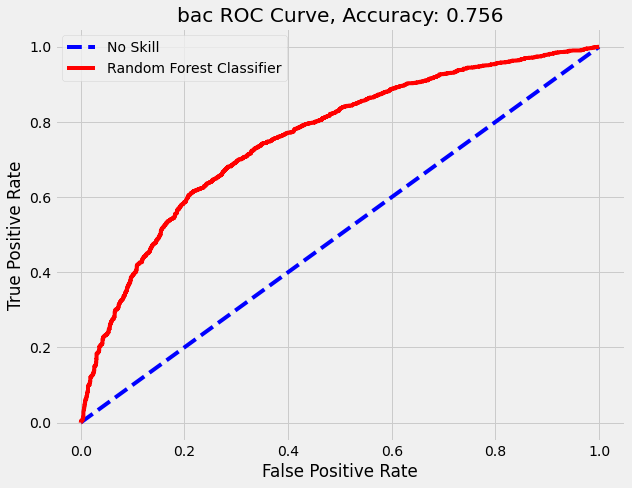

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

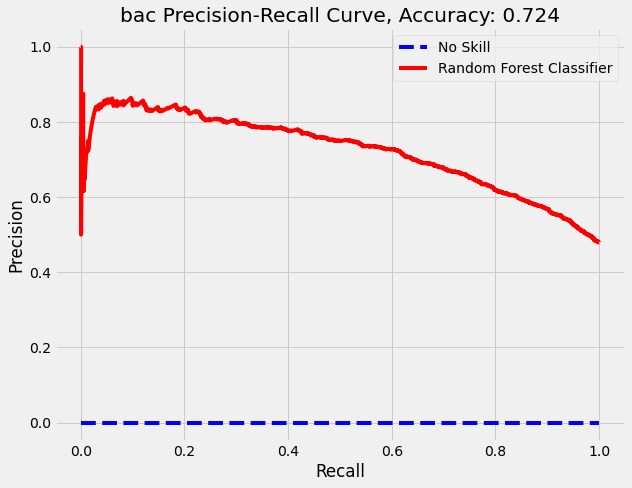

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

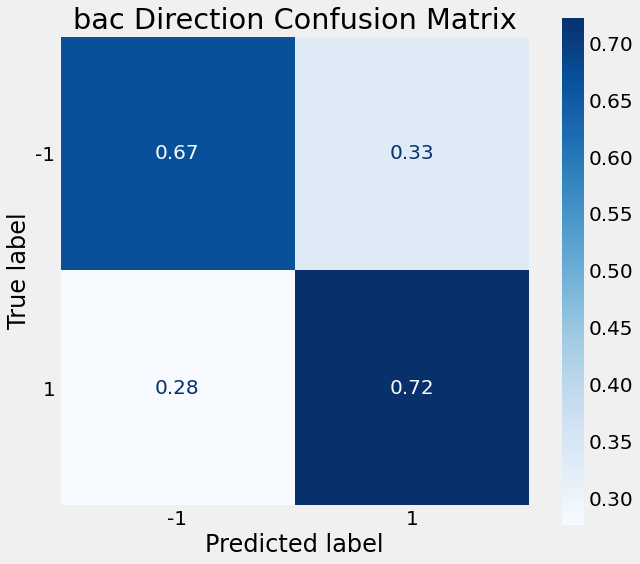

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6632524216055069'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          3.054000e+01
Low           2.991000e+01
Open          3.017000e+01
Close         3.026000e+01
Volume        4.595288e+07
Adj Close     3.026000e+01
oc           -2.983101e-03
hl            2.106323e-02
adj           7.658992e-03
5stdev_adj    8.337670e-03
5sma_adj      8.892194e-04
direction    -1.000000e+00
Name: 2021-01-05 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
last

oc            0.000000
hl            0.000000
5stdev_adj    0.003697
5sma_adj      0.000678
Name: 1973-03-01 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    12071.000000
mean         0.000545
std          0.024238
min         -0.289694
25%         -0.009524
50%          0.000000
75%          0.010136
max          0.352691
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name} {days_ahead} day(s) ahead')
else:
    print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

Sell or hold bac 1 day(s) ahead


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-29,30.250000,29.930000,30.170000,30.010000,33291900.0,30.010000,0.005303,0.010692,-0.003983,0.017198,0.001927,1,1,-0.001000
2020-12-30,30.219999,29.940001,30.000000,29.980000,26370100.0,29.980000,0.000667,0.009352,-0.001000,0.013648,0.005291,1,-1,-0.011007
2020-12-31,30.389999,29.900000,30.010000,30.309999,28696300.0,30.309999,-0.009997,0.016388,0.011007,0.006404,0.001741,-1,-1,0.009238
2021-01-04,30.570000,29.750000,30.459999,30.030001,51444700.0,30.030001,0.014117,0.027563,-0.009238,0.007974,0.000492,1,1,0.007659
2021-01-05,30.540001,29.910000,30.170000,30.260000,45952878.0,30.260000,-0.002983,0.021063,0.007659,0.008338,0.000889,-1,-1,-0.000000


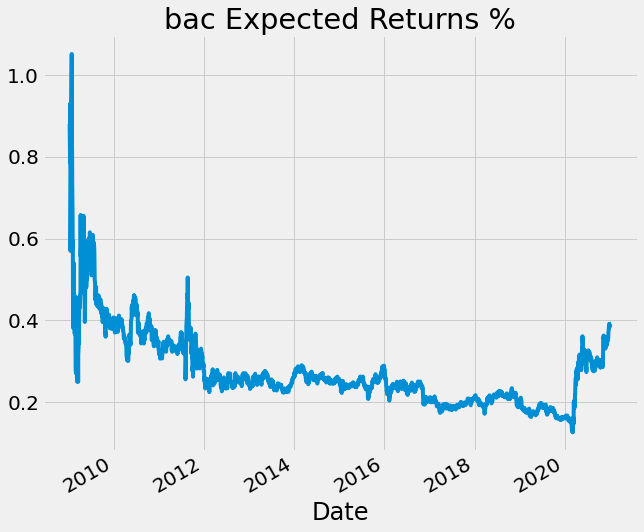

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

1.816331237206351

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

5.7244444953070746

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

In [22]:
# this takes a while, 10.5+ hours!
# stocks = [x for x in start_dates]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

### Recording Results